# MOVIE PREDICTION

###  Part 1 : Data and Library Imports

##### Importing Packages

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer

##### Loading in Data

In [5]:
prime_df = pd.read_csv('prime_titles.csv')
hulu_df=pd.read_csv('hulu_titles.csv')
netflix_df=pd.read_csv('netflix_titles.csv')
hbo_df = pd.read_csv('titles_hbo.csv')

hbo_creds=pd.read_csv('credits_hbo.csv')
prime_creds=pd.read_csv('credits_prime.csv')
hulu_creds=pd.read_csv('credits_hulu.csv')
netflix_creds=pd.read_csv('credits_netflix.csv')

##### Creating a new column to indicate which streaming platform the data is from 

In [6]:
prime_df = (prime_df.assign(service="amazon"))
hulu_df = (hulu_df.assign(service="hulu"))
netflix_df=(netflix_df.assign(service="netflix"))
hbo_df=(hbo_df.assign(service="hbo"))

In [7]:
prime_df=(pd.merge(prime_df, prime_creds, on='id'))
hulu_df=(pd.merge(hulu_df, hulu_creds, on='id'))
netflix_df=(pd.merge(netflix_df, netflix_creds, on='id'))
hbo_df=(pd.merge(hbo_df, hbo_creds, on='id'))

##### Combining both dataframes into one massive one

In [8]:
df=pd.concat([prime_df,hulu_df,netflix_df,hbo_df],axis=0,join='inner')

### Part 2 : Data Exploration

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300343 entries, 0 to 66392
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300343 non-null  object 
 1   title                 300342 non-null  object 
 2   type                  300343 non-null  object 
 3   description           300198 non-null  object 
 4   release_year          300343 non-null  int64  
 5   age_certification     178084 non-null  object 
 6   runtime               300343 non-null  int64  
 7   genres                300343 non-null  object 
 8   production_countries  300343 non-null  object 
 9   seasons               36845 non-null   float64
 10  imdb_id               287507 non-null  object 
 11  imdb_score            286073 non-null  float64
 12  imdb_votes            285893 non-null  float64
 13  tmdb_popularity       300317 non-null  float64
 14  tmdb_score            287815 non-null  float64
 15  s

In [10]:
print(df.describe)

<bound method NDFrame.describe of               id                title   type  \
0        ts20945    The Three Stooges   SHOW   
1        ts20945    The Three Stooges   SHOW   
2        ts20945    The Three Stooges   SHOW   
3        tm19248          The General  MOVIE   
4        tm19248          The General  MOVIE   
...          ...                  ...    ...   
66388  tm1067128            Algo Azul  MOVIE   
66389  tm1067128            Algo Azul  MOVIE   
66390  tm1067128            Algo Azul  MOVIE   
66391  tm1067128            Algo Azul  MOVIE   
66392   tm989132  The Infamous Future  MOVIE   

                                             description  release_year  \
0      The Three Stooges were an American vaudeville ...          1934   
1      The Three Stooges were an American vaudeville ...          1934   
2      The Three Stooges were an American vaudeville ...          1934   
3      During America’s Civil War, Union spies steal ...          1926   
4      During Ameri

In [11]:
df['actor'] = df.apply(lambda row: row['name'] if row['role'] == 'ACTOR' else None, axis=1)
df['director'] = df.apply(lambda row: row['name'] if row['role'] != 'ACTOR' else None, axis=1)

In [12]:
df = df.groupby('id', as_index=False).agg({
    'title': 'first',
    'type': 'first',
    'description': 'first',
    'release_year': 'first',
    'age_certification': 'first',
    'runtime': 'first',
    'genres': 'first',
    'production_countries': 'first',
    'seasons': 'first',
    'imdb_id': 'first',
    'imdb_score': 'first',
    'imdb_votes': 'first',
    'tmdb_popularity': 'first',
    'tmdb_score': 'first',
    'service': 'first',
    'actor': lambda x: list(x),
    'person_id': lambda x: list(x),
    'name': lambda x: list(x),
    'character': lambda x: list(x),
    'role': lambda x: list(x),
    'director': lambda x: list(x)
})


In [13]:
def extract_director(directors_list):
    for director in directors_list:
        if director is not None:
            if isinstance(director, dict):
                return director['name']
            else:
                return director
    return None

df['director'] = df['director'].apply(extract_director)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19225 entries, 0 to 19224
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    19225 non-null  object 
 1   title                 19224 non-null  object 
 2   type                  19225 non-null  object 
 3   description           19189 non-null  object 
 4   release_year          19225 non-null  int64  
 5   age_certification     9514 non-null   object 
 6   runtime               19225 non-null  int64  
 7   genres                19225 non-null  object 
 8   production_countries  19225 non-null  object 
 9   seasons               4460 non-null   float64
 10  imdb_id               17870 non-null  object 
 11  imdb_score            17669 non-null  float64
 12  imdb_votes            17641 non-null  float64
 13  tmdb_popularity       19215 non-null  float64
 14  tmdb_score            17586 non-null  float64
 15  service            

##### Dealing with missing values

In [15]:
df.isna().sum()

id                          0
title                       1
type                        0
description                36
release_year                0
age_certification        9711
runtime                     0
genres                      0
production_countries        0
seasons                 14765
imdb_id                  1355
imdb_score               1556
imdb_votes               1584
tmdb_popularity            10
tmdb_score               1639
service                     0
actor                       0
person_id                   0
name                        0
character                   0
role                        0
director                 4035
dtype: int64

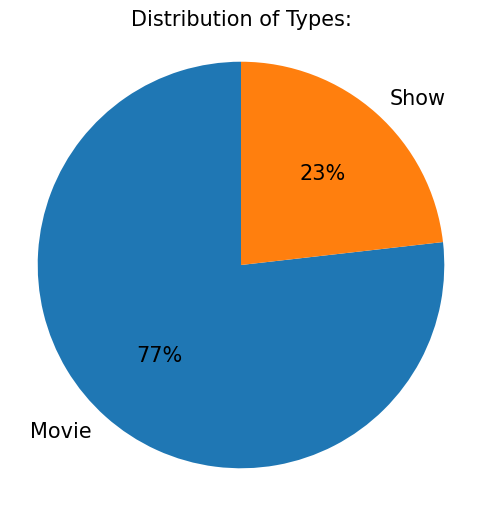

In [16]:
plt.figure(figsize=(10,6))
plt.title('Distribution of Types:', fontsize=15)
plt.pie(df.type.value_counts(), 
        labels=['Movie', 'Show'],
        textprops={"fontsize":15},
        radius=1.1, startangle=90,
        autopct='%.0f%%')
plt.show()

In [17]:
movie_count = df[df['type'] == 'MOVIE'].shape[0]
show_count = df[df['type'] == 'SHOW'].shape[0]
print(f"Number of movies: {movie_count}")
print(f"Number of TV shows: {show_count}")

Number of movies: 14765
Number of TV shows: 4460


##### Summary variable

In [18]:
descriptions = (pd.DataFrame(df.description.dropna())).reset_index()
mas = []
for i in range(5832):
  w = descriptions.description[i]
  ww = w.split()
  mas.append(ww)

data = []
for i in mas:
    for j in range(len(i)):
        data.append(i[j].lower())
        
big_string=''
for i in range(len(data)):
    big_string+=(data[i]+' ')

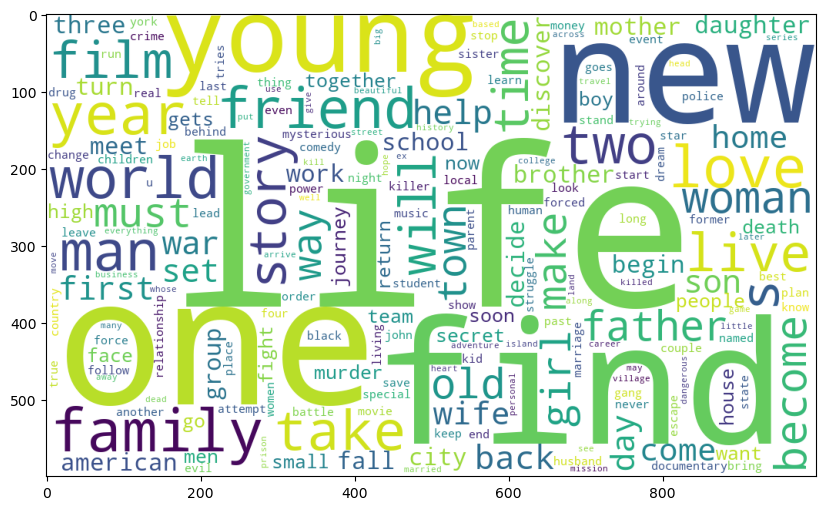

In [19]:
wordCloud = WordCloud(width = 1000, height = 600, random_state=1,background_color='white', collocations=False).generate(big_string)

plt.figure(figsize=(10,6))
plt.imshow(wordCloud)

#### Part 3 : Data Cleaning

##### Genre and production country columns are lists- need to get a top category

#####  1. genre 

In [20]:
df['genres'] = df['genres'].str.strip("[]'")
genres_df = df['genres'].str.split(', ', expand=True)
genres_df.columns = [f'genre_{i}' for i in range(genres_df.shape[1])]
df = pd.concat([df, genres_df], axis=1)
df['genre_0'] = df['genre_0'].str.strip("'")
df['genre_1'] = df['genre_1'].str.strip("'")
df['genre_2'] = df['genre_2'].str.strip("'")
df['genre_3'] = df['genre_3'].str.strip("'")
df['genre_4'] = df['genre_4'].str.strip("'")
df['genre_5'] = df['genre_5'].str.strip("'")
df['genre_6'] = df['genre_6'].str.strip("'")
df['genre_7'] = df['genre_7'].str.strip("'")
df['genre_8'] = df['genre_8'].str.strip("'")


df.drop(['genres'], axis=1, inplace=True)

In [21]:
df['genre_0'].unique()

array(['scifi', 'western', 'drama', '', 'action', 'music', 'romance',
       'comedy', 'horror', 'thriller', 'animation', 'fantasy',
       'documentation', 'crime', 'family', 'sport', 'history', 'war',
       'european', 'reality'], dtype=object)

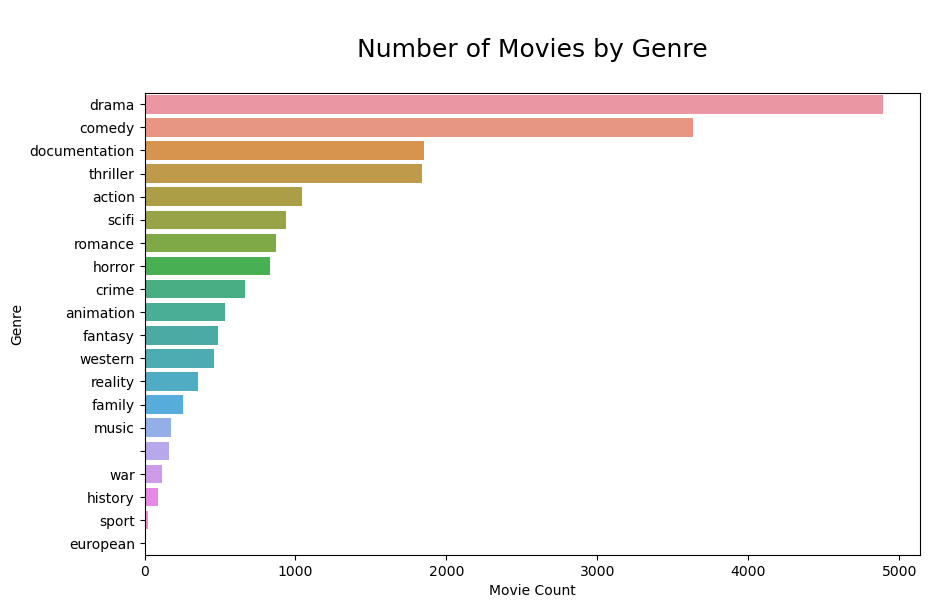

In [22]:
bp_df = pd.DataFrame(df.genre_0.value_counts())
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nNumber of Movies by Genre\n', fontsize=18)
sns.countplot(y=df.genre_0, order=order)
plt.xlabel('Movie Count')
plt.ylabel('Genre')
plt.show()

#####  2. Seasons  

In [23]:
df.loc[df['type'] == 'MOVIE', ['seasons']] = 0

#####  3. Production Countries 

In [24]:
df['production_countries'] = df['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')
df['lead_prod_country'] = df['production_countries'].str.split(',').str[0]

# Let's also add a number of countries, envolved in movie making, so that we save a little more data
df['prod_countries_cnt'] = df['production_countries'].str.split(',').str.len()
df.lead_prod_country = df.lead_prod_country.replace('', np.nan)

/var/folders/sk/lkcllkb10nl1_6_s1z575s300000gp/T/ipykernel_6101/2226315985.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['production_countries'] = df['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')


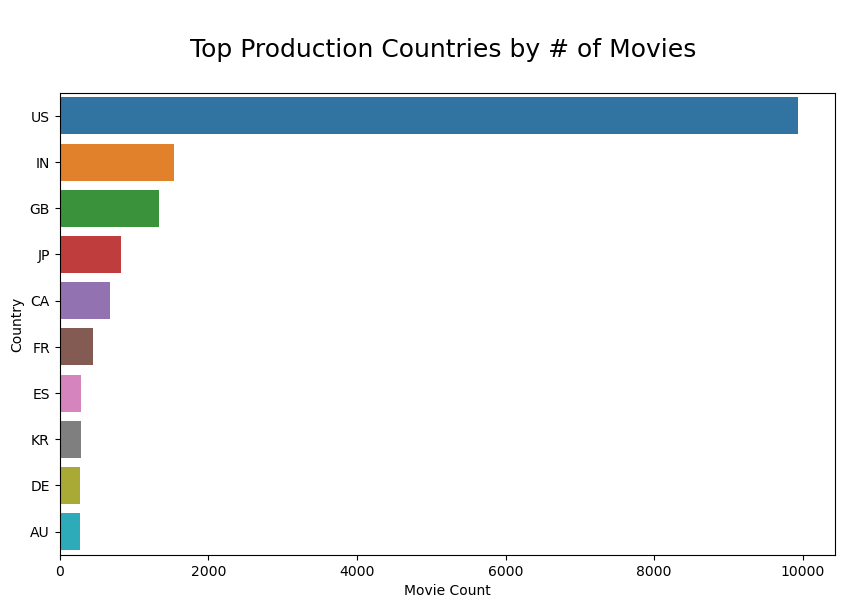

In [25]:
bp_df = pd.DataFrame(df.lead_prod_country.value_counts()).head(10)
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nTop Production Countries by # of Movies \n', fontsize=18)
sns.countplot(y=df.lead_prod_country, order=order)
plt.xlabel('Movie Count')
plt.ylabel('Country')
plt.show()

In [26]:
#df.dropna(inplace=True)

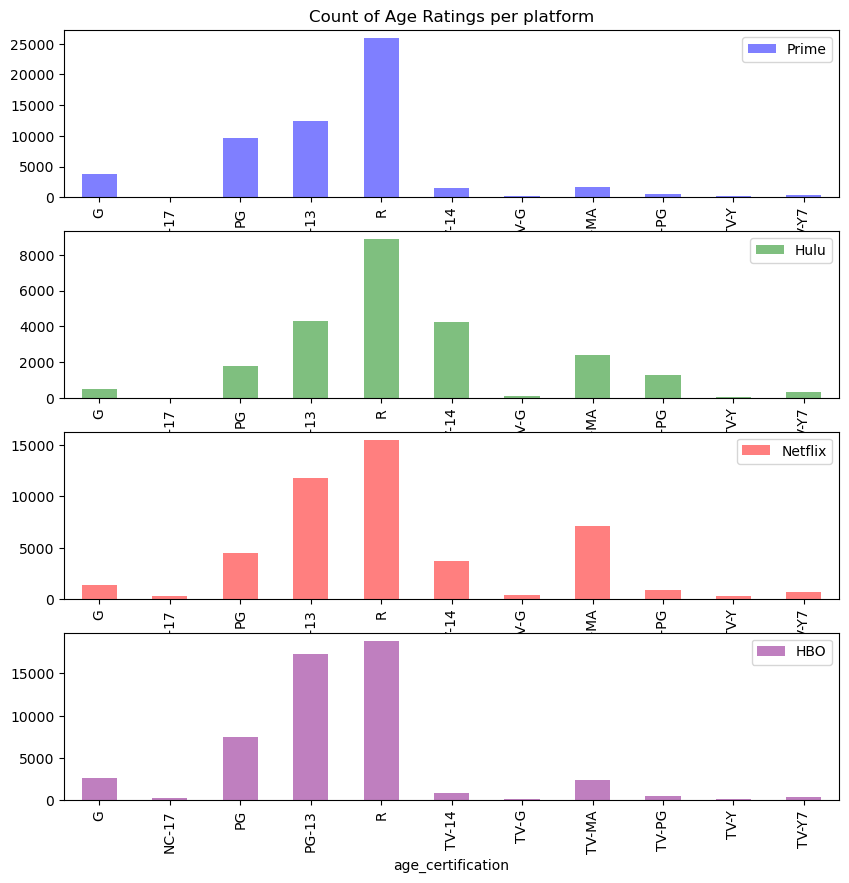

In [27]:
fig, ax = plt.subplots(4,figsize=(10, 10))

# Plot the first line
prime_df.groupby(['age_certification']).size().plot.bar(ax=ax[0], color='blue', alpha=0.5, label='Prime')

# Plot the second line
hulu_df.groupby(['age_certification']).size().plot.bar(ax=ax[1], color='green', alpha=0.5, label='Hulu')
# Plot the third line
netflix_df.groupby(['age_certification']).size().plot.bar(ax=ax[2], color='red', alpha=0.5, label='Netflix')
# Plot the forth line
hbo_df.groupby(['age_certification']).size().plot.bar(ax=ax[3], color='purple', alpha=0.5, label='HBO')

# Set the title and labels
ax[0].set_title('Count of Age Ratings per platform')
ax[2].set_xlabel('Age Certification')



# Set the legend
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

# Show the plot
plt.show()

#### Cleaning Actor Column

In [28]:
# converting the list to a string

In [29]:
df['actor'] = df['actor'].apply(lambda x: ' '.join([a if a is not None else '' for a in x]))

#####  3. Weighted ratings

In [30]:
v=df['imdb_votes']
R=df['imdb_score']
c=df['imdb_score'].mean()
m=df['imdb_votes'].quantile(0.9)

In [31]:
df['weighted_avg']=((R*v)+ (c*m))/(v+m)

Text(0, 0.5, 'Movie Name')

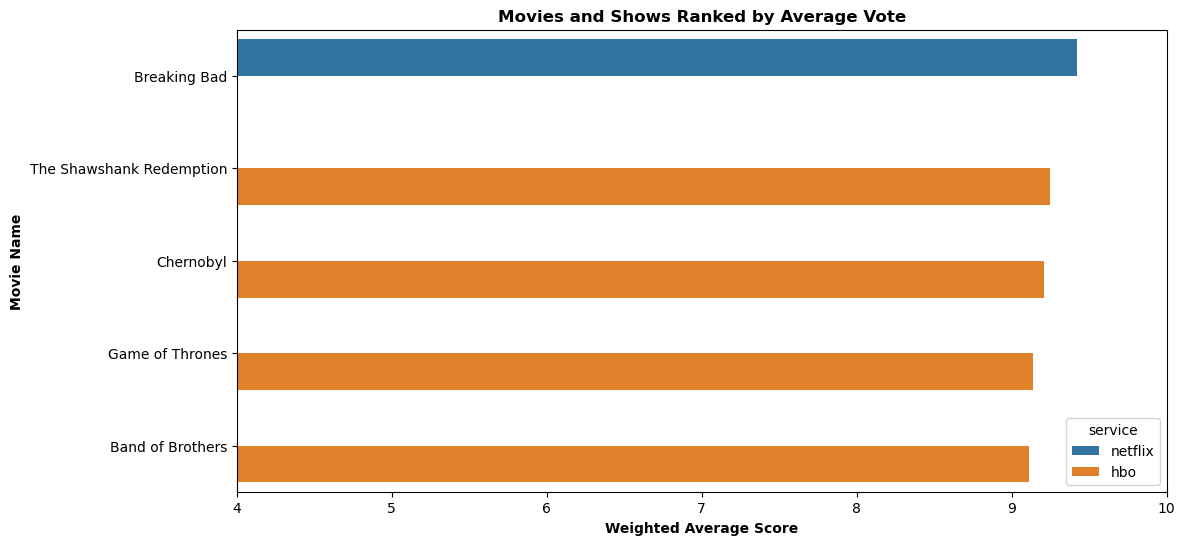

In [32]:
weight_average= df.sort_values('weighted_avg',ascending=False)


plt.figure(figsize=(12, 6))
axis1=sns.barplot(x=weight_average['weighted_avg'].head(5),y=weight_average['title'].head(5),
                   hue=weight_average['service'].head(5),data=weight_average)
plt.xlim(4,10)

plt.title('Movies and Shows Ranked by Average Vote',weight='bold')
plt.xlabel('Weighted Average Score',weight='bold')
plt.ylabel('Movie Name',weight='bold')


In [33]:
print(weight_average['title'].head(10),"      ",weight_average['weighted_avg'].head(10))

17661                                     Breaking Bad
1854                          The Shawshank Redemption
19021                                        Chernobyl
15209                                  Game of Thrones
15088                                 Band of Brothers
10786                                  The Dark Knight
15243                                   Rick and Morty
15756                                         The Wire
2803     The Lord of the Rings: The Return of the King
17298                       Avatar: The Last Airbender
Name: title, dtype: object        17661    9.420585
1854     9.247729
19021    9.210503
15209    9.135430
15088    9.111781
10786    8.953115
15243    8.947715
15756    8.934153
2803     8.933076
17298    8.911637
Name: weighted_avg, dtype: float64


In [34]:
print(weight_average[['title', 'weighted_avg']].head(10))

                                               title  weighted_avg
17661                                   Breaking Bad      9.420585
1854                        The Shawshank Redemption      9.247729
19021                                      Chernobyl      9.210503
15209                                Game of Thrones      9.135430
15088                               Band of Brothers      9.111781
10786                                The Dark Knight      8.953115
15243                                 Rick and Morty      8.947715
15756                                       The Wire      8.934153
2803   The Lord of the Rings: The Return of the King      8.933076
17298                     Avatar: The Last Airbender      8.911637


In [35]:
print(df['service'].nunique())

4


In [36]:
df.corr()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,prod_countries_cnt,weighted_avg
release_year,1.000000,-0.048988,0.038216,0.024434,-0.005286,0.074379,0.143127,0.041268,-0.042537
runtime,-0.048988,1.000000,-0.388854,-0.146373,0.158323,-0.020891,-0.198378,0.135602,-0.005001
seasons,0.038216,-0.388854,1.000000,0.215851,0.037465,0.127256,0.211140,-0.064168,0.206675
imdb_score,0.024434,-0.146373,0.215851,1.000000,0.206806,0.071861,0.633281,0.020243,0.523006
imdb_votes,-0.005286,0.158323,0.037465,0.206806,1.000000,0.201364,0.154168,0.088889,0.602519
tmdb_popularity,0.074379,-0.020891,0.127256,0.071861,0.201364,1.000000,0.109545,0.009738,0.166118
tmdb_score,0.143127,-0.198378,0.211140,0.633281,0.154168,0.109545,1.000000,-0.001636,0.375559
prod_countries_cnt,0.041268,0.135602,-0.064168,0.020243,0.088889,0.009738,-0.001636,1.000000,0.027508
weighted_avg,-0.042537,-0.005001,0.206675,0.523006,0.602519,0.166118,0.375559,0.027508,1.000000


#####  4. Release Year

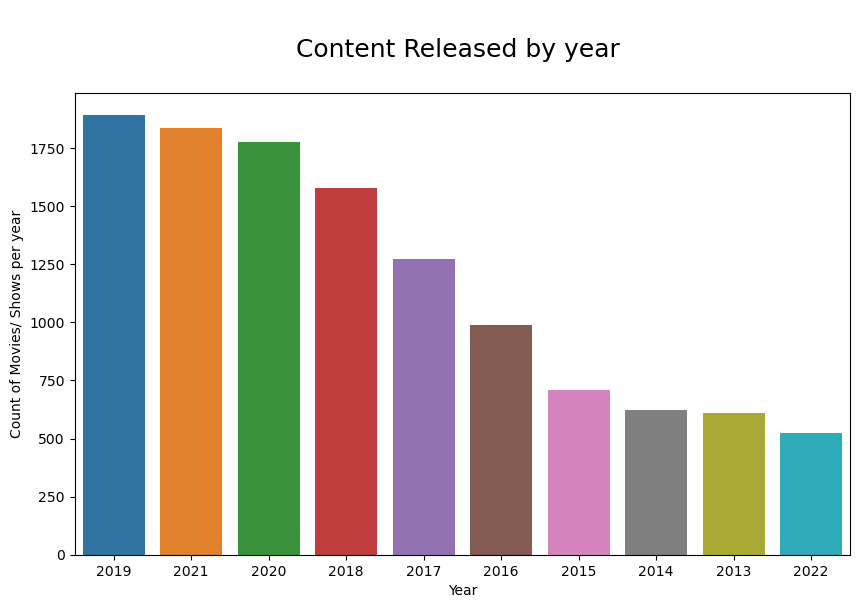

In [37]:
bp_df = pd.DataFrame(df.release_year.value_counts()).head(10)
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nContent Released by year \n', fontsize=18)
sns.countplot(x=df.release_year, order=order)
plt.xlabel('Year')
plt.ylabel('Count of Movies/ Shows per year')
plt.show()

In [38]:
df.columns

Index(['id', 'title', 'type', 'description', 'release_year',
       'age_certification', 'runtime', 'production_countries', 'seasons',
       'imdb_id', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score',
       'service', 'actor', 'person_id', 'name', 'character', 'role',
       'director', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4',
       'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9',
       'lead_prod_country', 'prod_countries_cnt', 'weighted_avg'],
      dtype='object')

###### Checking for and getting rid of NA vals

In [39]:
df.drop(df.loc[((df['tmdb_score'].isna()) & (df['tmdb_popularity'].isna()))].index, 
                axis = 0, inplace = True)

In [40]:
((df.isnull().sum()/df.shape[0])*100).sort_values(ascending = False)

genre_9                 99.994796
genre_8                 99.911527
genre_7                 99.687744
genre_6                 99.021598
genre_5                 97.054385
genre_4                 91.647151
genre_3                 79.354671
genre_2                 56.013531
age_certification       50.491803
genre_1                 26.786365
director                20.983607
tmdb_score               8.477752
weighted_avg             8.227947
imdb_votes               8.227947
imdb_score               8.082227
imdb_id                  7.051782
lead_prod_country        3.143378
description              0.171741
prod_countries_cnt       0.000000
genre_0                  0.000000
id                       0.000000
role                     0.000000
character                0.000000
title                    0.000000
person_id                0.000000
actor                    0.000000
service                  0.000000
tmdb_popularity          0.000000
seasons                  0.000000
production_cou

In [41]:
df[(df.type == 'SHOW') & (df.imdb_score >= 9) & (df.tmdb_score>=9)][['actor', 'imdb_score', 'tmdb_score', 'title']].reset_index().drop('index', axis = 1)

,actor,imdb_score,tmdb_score,title
0,Lilía Herrera Mosk Marrero Carlos Kapistrán Mi...,9.0,10.000,Corazón Contento
1,Hailee Steinfeld Ella Purnell Kevin Alejandro ...,9.0,9.081,Arcane
2,William Toti,9.3,9.100,9/11: One Day in America
3,Jonathan Roumie Elizabeth Tabish Jordan Walker...,9.4,9.400,The Chosen
4,Alyssa Chia James Wen Kang Ren Wu Chen Yu Pets...,9.0,9.400,The World Between Us


# Part 3. Model Building 

## Similarity Score

In [42]:
df['index_column'] = df.index
features = ['title', 'type', 'genre_0', 'description','actor','director', 'imdb_score', 'tmdb_popularity', 'tmdb_score']
for feature in features:
    df[feature] = df[feature].fillna('')
def combined_features(row):
    return row['title']+" "+row['type']+" "+row['genre_0']+" "+row['description']+" "+row['actor']+" "+row['director']+" "+str(row['imdb_score'])+" "+str(row['tmdb_popularity'])+" "+str(row['tmdb_score'])
                                                                                                                    
df["combined_features"] = df.apply(combined_features, axis =1)
vectorizer = CountVectorizer()
matrix_transform = vectorizer.fit_transform(df["combined_features"])
cosine_similarity_rm = cosine_similarity(matrix_transform)

In [43]:
def select_movie(df, movie_title, number_of_recommendations):
    features = ['title', 'type', 'genre_0', 'description', 'actor', 'director', 'imdb_score', 'tmdb_popularity', 'tmdb_popularity']
    selected_movie = pd.DataFrame(df[df['title'] == movie_title][features].iloc[0]).transpose()
    vectorizer = CountVectorizer()
    feature_matrix = vectorizer.fit_transform(df[features].apply(lambda x: ' '.join(str(i) for i in x)))
    cosine_sim = cosine_similarity(feature_matrix)
    movie_index = df[df['title'] == movie_title].index[0]
    similarity_scores = list(enumerate(cosine_sim[movie_index]))
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_movies = [df.iloc[i[0]]['title'] for i in sorted_scores[1:number_of_recommendations+1]]
    
    return top_movies

In [44]:
recommendations = select_movie(df, 'The Lucky Texan', 10)
for recommendation in recommendations:
    print(recommendation)

The Matrix
Je suis Karl
Bad Luck Banging or Loony Porn
Boonie Bears: The Wild Life
Deep Down
Zone 414
Takers
Wave of Cinema: Surat Dari Timur


# Model Evaluation

In [45]:
train_data, test_data, train_labels, test_labels = train_test_split(df['combined_features'], df['type'], test_size=0.2, random_state=42)
cv = CountVectorizer()
train_count_matrix = cv.fit_transform(train_data)
test_count_matrix = cv.transform(test_data)
clf = MultinomialNB()
clf.fit(train_count_matrix, train_labels)
predicted_labels = clf.predict(test_count_matrix)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Precision: 0.8789984906204776
Recall: 0.8836846213895394
F1 Score: 0.8766457653940506


# Cluster Analysis

In [47]:
data=df

In [65]:
dummies = pd.get_dummies(data[['type', 'production_countries', 'genre_0', 'director', 'actor']], drop_first=True)
data_1 = pd.concat([df, dummies], axis=1)


In [66]:
data_1.describe().T

,count,mean,std,min,25%,50%,75%,max
release_year,19215.0,2006.049597,22.229035,1901.000000,2004.0000,2016.000,2019.0000,2022.000
runtime,19215.0,82.221181,35.583313,0.000000,56.0000,88.000,103.0000,540.000
seasons,19215.0,0.658704,2.183759,0.000000,0.0000,0.000,0.0000,63.000
imdb_votes,17634.0,23607.908869,94933.710802,5.000000,291.0000,1489.000,8512.0000,2555504.000
tmdb_popularity,19215.0,16.118266,69.055776,0.000011,1.9675,4.766,12.0235,4447.894
...,...,...,...,...,...,...,...,...
actor_Наурызбек Смагулов,19215.0,0.000052,0.007214,0.000000,0.0000,0.000,0.0000,1.000
actor_张伟 Tan Xiao Yuan Xin,19215.0,0.000052,0.007214,0.000000,0.0000,0.000,0.0000,1.000
actor_秋山竜次,19215.0,0.000052,0.007214,0.000000,0.0000,0.000,0.0000,1.000
actor_高晓菲 Zhang Jiayi Wang Luodan Jiang Shan Ke Lan,19215.0,0.000052,0.007214,0.000000,0.0000,0.000,0.0000,1.000


In [ ]:
numeric_columns = data_1.select_dtypes(include=np.number).columns.tolist()
data_numeric = data_1[numeric_columns]

imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(data_numeric)

data_std = (data_imputed - data_imputed.mean()) / data_imputed.std()


pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(data_std)

# k-means

In [ ]:
K = range(10, 80)
models = [KMeans(n_clusters = k, random_state=8, n_init=10,max_iter = 100).fit(data_pca) for k in K]
dist = [model.inertia_ for model in models]

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(K, dist, marker='o', color='#a30052')
plt.xlabel('Number of clusters')
plt.ylabel('')
plt.title('\nElbow Curve\n', fontsize=18)
plt.show()

About 35 clusters before curve starts looking flat. Checking from range 20-40

In [ ]:
models_150 = KMeans(n_clusters=700, random_state=8, n_init=10,max_iter = 1000)
model_labels_150 = models_150.fit_predict(data_pca)
silhouette_avg_150 = silhouette_score(data_pca, model_labels_150)
print("For n_clusters =", 150, "The average silhouette_score is :", silhouette_avg_150)

In [ ]:
df[f'{i}_clusters'] = models_150.labels_

In [ ]:
def get_recommendations_cluster(movie_name, num_recommendations):
    idx = data[data['title'] == movie_name].index[0]
    label = model_labels[idx]
    cluster = np.where(model_labels == label)[0]
    distances = pairwise_distances(data_pca[idx].reshape(1,-1), data_pca[cluster], metric='cosine')[0]
    rec_indices = np.argsort(distances)[:num_recommendations]
    return data['title'].iloc[cluster[rec_indices]].tolist()

In [ ]:
get_recommendations_cluster('The Lucky Texan', 10)

In [328]:
cosine_sim=cosine_similarity(matrix_transform)
def get_recommendations(movie_name, num_recommendations):
    if movie_name not in df['title'].tolist():
        print("Movie not found in database. Enter another movie")
        return
    
    idx = df[df['title'] == movie_name].index[0]
    similarity_scores = list(enumerate(cosine_sim[idx]))
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_scores = sorted_scores[1:num_recommendations+1]
    movie_indices = [i[0] for i in top_scores]
    scores = [i[1] for i in top_scores]
    rec_movies = df['title'].iloc[movie_indices].tolist()[::-1]
    scores = scores[::-1]
    plt.barh(rec_movies, scores)
    plt.xlabel('Similarity Score')
    plt.ylabel('Recommended Movies')
    plt.title('Top {} Recommendations for {}'.format(num_recommendations, movie_name))
    for i, v in enumerate(scores):
        plt.text(v + 0.01, i, str(round(v, 2)), color='blue', fontweight='bold')
    plt.show()
    return rec_movies

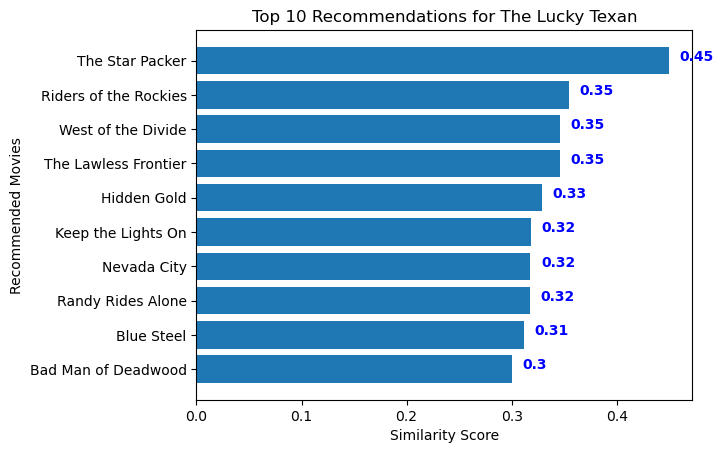

['Bad Man of Deadwood',
 'Blue Steel',
 'Randy Rides Alone',
 'Nevada City',
 'Keep the Lights On',
 'Hidden Gold',
 'The Lawless Frontier',
 'West of the Divide',
 'Riders of the Rockies',
 'The Star Packer']

In [329]:
get_recommendations('The Lucky Texan', 10)

# Prediction

In [48]:
dummies = pd.get_dummies(data[['type', 'genre_0', 'director', 'actor','description']], drop_first=True)

data_1 = pd.concat([df, dummies], axis=1)

In [49]:
X = df_pca_60
df['weighted_avg'].fillna((df['weighted_avg'].mean()), inplace=True)
y = df['weighted_avg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [LinearRegression(), DecisionTreeRegressor(random_state=70), RandomForestRegressor(n_estimators=100, random_state=42), SVR()]

r2_scores = []
mse_scores = []

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2_scores.append(r2)
    mse_scores.append(mse)

for i in range(len(models)):
    print("Model:", models[i])
    print("R-squared:", r2_scores[i])
    print("Mean squared error:", mse_scores[i])
    print("\n")

best_model_index = r2_scores.index(max(r2_scores))
best_model = models[best_model_index]
print("The best model based on R-squared is:", best_model)


NameError: name 'df_pca_60' is not defined

In [310]:
dummies = pd.get_dummies(data[['type', 'genre_0', 'director', 'actor','description']], drop_first=True)

data_1 = pd.concat([df, dummies], axis=1)

In [311]:
df.head()

,title,type,description,release_year,age_certification,runtime,production_countries,seasons,imdb_score,imdb_votes,...,director,genre_0,genre_1,genre_2,lead_prod_country,prod_countries_cnt,weighted_avg,index_column,combined_features,282086_clusters
0,The Lucky Texan,MOVIE,"Jerry Mason, a young Texan, and Jake Benson, a...",1934,None,61,US,0.0,5.6,1213.0,...,Robert N. Bradbury,western,action,romance,US,1,6.058088,0,"The Lucky Texan MOVIE western Jerry Mason, a y...",129
1,Boonie Bears: The Wild Life,MOVIE,Bear brothers Briar and Bramble set off on an ...,2021,None,99,CN,0.0,5.4,117.0,...,Leon Ding,scifi,animation,None,CN,1,6.080710,1,Boonie Bears: The Wild Life MOVIE scifi Bear b...,383
2,Bad Luck Banging or Loony Porn,MOVIE,"Emi, a school teacher, finds her career and re...",2021,None,106,"HR, LU, GB, RO, CH, CZ",0.0,6.6,6465.0,...,Radu Jude,drama,comedy,None,HR,6,6.205653,2,Bad Luck Banging or Loony Porn MOVIE drama Emi...,1
3,Bad Cupid,MOVIE,Archie is a God on a mission to ensure that tr...,2021,None,81,,0.0,4.4,181.0,...,Diane Cossa,romance,comedy,None,NaN,1,6.070129,3,Bad Cupid MOVIE romance Archie is a God on a m...,41
4,Digging to Death,MOVIE,David Van Owen moves into a mysterious house a...,2021,None,96,US,0.0,4.5,464.0,...,Michael P. Blevins,horror,thriller,None,US,1,6.050310,4,Digging to Death MOVIE horror David Van Owen m...,6


In [50]:
movie_name = input("Enter the name of the movie: ")

lr = LinearRegression()
lr.fit(X_train, y_train)
predicted_score = lr.predict(X_test)

print("The predicted score for '{}' is: {:.2f}".format(movie_name, predicted_score[0]))

Enter the name of the movie:  Normal People


NameError: name 'X_train' is not defined

In [313]:
movie_name = input("Enter the name of the movie: ")
print("The predicted score for '{}' is: {:.2f}".format(movie_name, predicted_score[0]))

Enter the name of the movie:  Brooklyn Nine-Nine


The predicted score for 'Brooklyn Nine-Nine' is: 6.17


In [314]:
movie_name = input("Enter the name of the movie: ")
print("The predicted score for '{}' is: {:.2f}".format(movie_name, predicted_score[0]))

Enter the name of the movie:  Normal People


The predicted score for 'Normal People' is: 6.17


In [315]:
data_1.dropna(inplace=True)

In [316]:
predicted_scores = best_model.predict(X)

df['predicted_score'] = predicted_scores

In [ ]:
df.head()

,title,type,description,release_year,age_certification,runtime,production_countries,seasons,imdb_score,imdb_votes,...,genre_0,genre_1,genre_2,lead_prod_country,prod_countries_cnt,weighted_avg,index_column,combined_features,282086_clusters,predicted_score
0,The Lucky Texan,MOVIE,"Jerry Mason, a young Texan, and Jake Benson, a...",1934,None,61,US,0.0,5.6,1213.0,...,western,action,romance,US,1,6.058088,0,"The Lucky Texan MOVIE western Jerry Mason, a y...",129,6.074617
1,Boonie Bears: The Wild Life,MOVIE,Bear brothers Briar and Bramble set off on an ...,2021,None,99,CN,0.0,5.4,117.0,...,scifi,animation,None,CN,1,6.080710,1,Boonie Bears: The Wild Life MOVIE scifi Bear b...,383,5.929274
2,Bad Luck Banging or Loony Porn,MOVIE,"Emi, a school teacher, finds her career and re...",2021,None,106,"HR, LU, GB, RO, CH, CZ",0.0,6.6,6465.0,...,drama,comedy,None,HR,6,6.205653,2,Bad Luck Banging or Loony Porn MOVIE drama Emi...,1,6.205592
3,Bad Cupid,MOVIE,Archie is a God on a mission to ensure that tr...,2021,None,81,,0.0,4.4,181.0,...,romance,comedy,None,NaN,1,6.070129,3,Bad Cupid MOVIE romance Archie is a God on a m...,41,6.140577
4,Digging to Death,MOVIE,David Van Owen moves into a mysterious house a...,2021,None,96,US,0.0,4.5,464.0,...,horror,thriller,None,US,1,6.050310,4,Digging to Death MOVIE horror David Van Owen m...,6,6.038202


In [ ]:
def predict_movie_score(movie_name, data):
    movie_index = data[data['title'] == movie_name].index[0]

    movie_features = data.loc[movie_index, 'combined_features']

    predicted_score = data.loc[movie_index, 'predicted_score']

    result = pd.DataFrame({'title': movie_name, 'predicted_score': predicted_score}, index=[0])

    return result

In [ ]:
movie_name = "The Lucky Texan"
result = predict_movie_score(movie_name, data)
print(result)

             title  predicted_score
0  The Lucky Texan         6.074617


In [ ]:
movie_name = "Normal People"
result = predict_movie_score(movie_name, data)
print(result)

           title  predicted_score
0  Normal People         6.492253


In [ ]:
movie_name = "Brooklyn Nine-Nine"
result = predict_movie_score(movie_name, data)
print(result)

                title  predicted_score
0  Brooklyn Nine-Nine         6.425256


In [ ]:
max_score_index = df['predicted_score'].idxmax()
max_score_movie = df.loc[max_score_index, 'title']
max_score = df.loc[max_score_index, 'predicted_score']
print(f"The movie with the highest predicted score is {max_score_movie} with a score of {max_score}.")

The movie with the highest predicted score is Meerkat Manor with a score of 6.782162657979973.
